# Advanced Lane Lines

### Initial Camera Calibration

(array([[  1.15158804e+03,   0.00000000e+00,   6.66167057e+02],
        [  0.00000000e+00,   1.14506859e+03,   3.86440204e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[ -2.35510339e-01,  -7.90388401e-02,  -1.28492203e-03,
           8.25970403e-05,   7.22743173e-02]]))

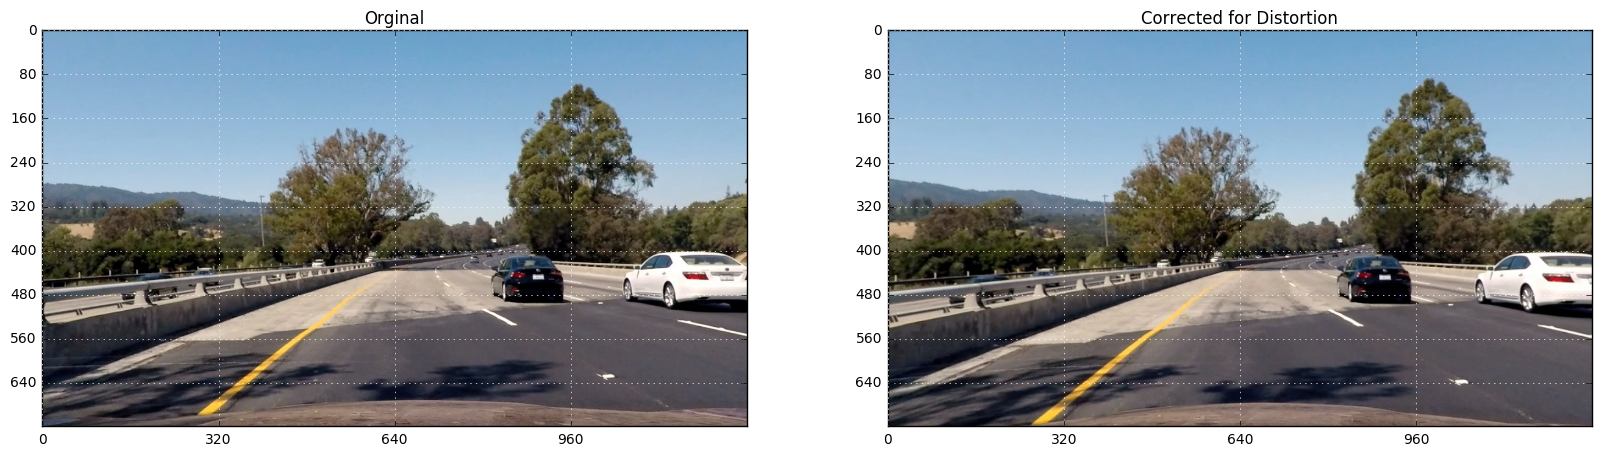

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob

from CameraOperations import show_grid, correct_distortion, calibrate_camera_from_folder

image = mpimg.imread("./corrected_images/adj_test4.jpg")

mtx, dist = calibrate_camera_from_folder("./camera_cal",name_pattern="calibration*.jpg", counts=(9,6))
un_dst = correct_distortion(image, mtx, dist)

show_grid((image, un_dst), ("Orginal", "Corrected for Distortion"), ticks=(320,80))

global_mtx = mtx
global_dist = dist
global_mtx, global_dist

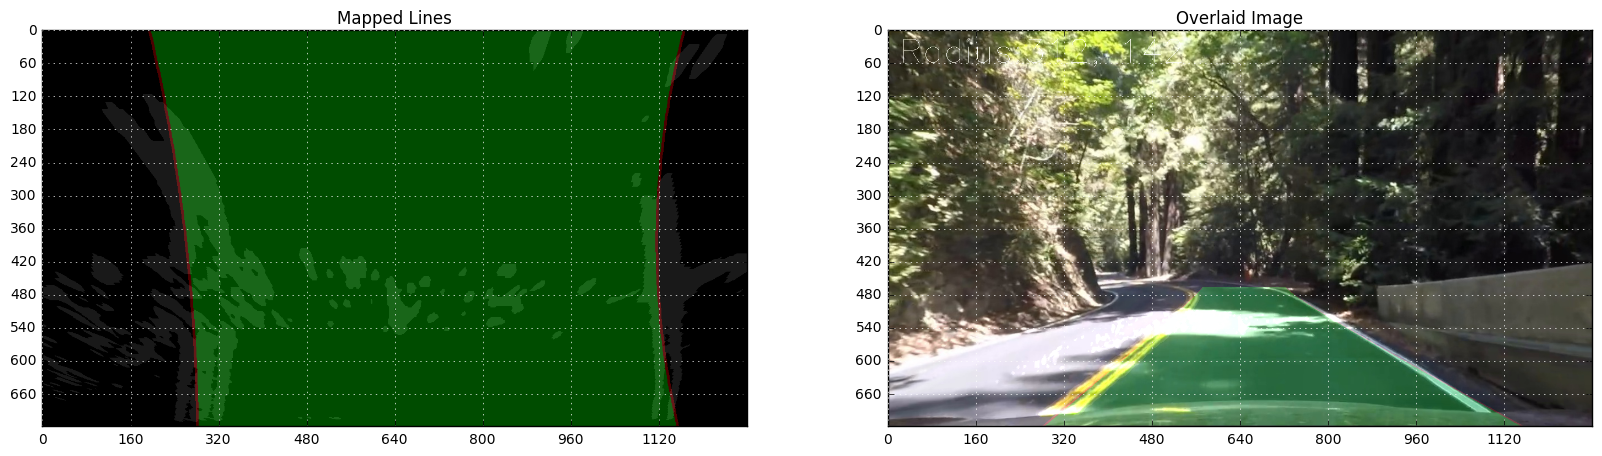

In [34]:
#from LaneOperations import map_lane_lines
from CameraOperations import combined_SR_threshold, perspective_transform, sobel_LR_threshold, sobel_LSR_threshold
from ImageProcessing import gaussian_blur
from LaneOperations import find_window_centroids, map_lane_lines

img_id = "1189"
image = mpimg.imread("./debug_images-harder_challenge_video/{0}.jpg".format(img_id))
un_dst = correct_distortion(image, global_mtx, global_dist)
mapped_lanes, lane_markings, cache = map_lane_lines(un_dst, window_width=75, window_height=48, margin=2)
#, DEBUG=True, DEBUG_ID=img_id)
show_grid((mapped_lanes, lane_markings), ("Mapped Lines", "Overlaid Image"), ticks=(160,60))


### Test on multiple images

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
from CameraOperations import show_grid, correct_distortion, calibrate_camera_from_folder
#from LaneOperations import map_lane_lines

test_images = os.listdir("corrected_images/")

for img in test_images:
    image = mpimg.imread('corrected_images/'+img)
    mapped_lanes, lane_markings,cache = map_lane_lines(image,window_width=75,window_height=48,margin=2)#,DEBUG=True,DEBUG_ID=img)
    show_grid((mapped_lanes, lane_markings), ("Mapped Lines "+img, "Overlaid Image"))


### Try it on video

In [ ]:
import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

idx=0
cache = None
def make_frame_lane_markings(image):
    global idx
    global cache
    un_dst = correct_distortion(image, global_mtx, global_dist)
    mapped_lanes, lane_markings, cache = map_lane_lines(un_dst, window_width=75, window_height=48, margin=2, cache=cache)
    mpimg.imsave("debug_images/{0}_overlay.jpg".format(idx), lane_markings)
    mpimg.imsave("debug_images/{0}_mapped_lanes.jpg".format(idx), mapped_lanes)
    mpimg.imsave("debug_images/{0}.jpg".format(idx), image)
    idx = idx + 1
    return lane_markings

clip_output = './marked_harder_challenge_video.mp4' #"harder_challenge_video.mp4"
clip_handle = VideoFileClip("harder_challenge_video.mp4", audio=False)
img_clip = clip_handle.fl_image(make_frame_lane_markings) 
%time img_clip.write_videofile(clip_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))

### Trying various filters to find the best match

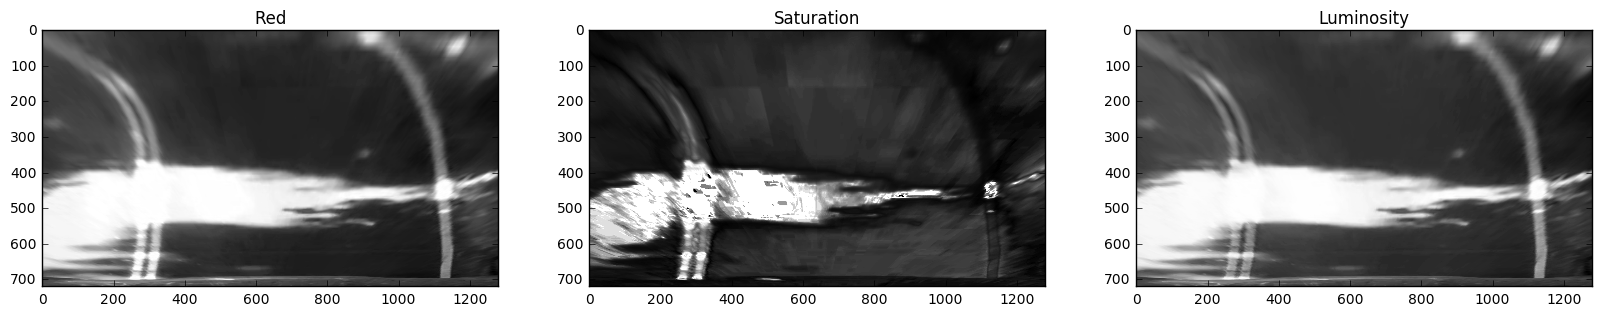

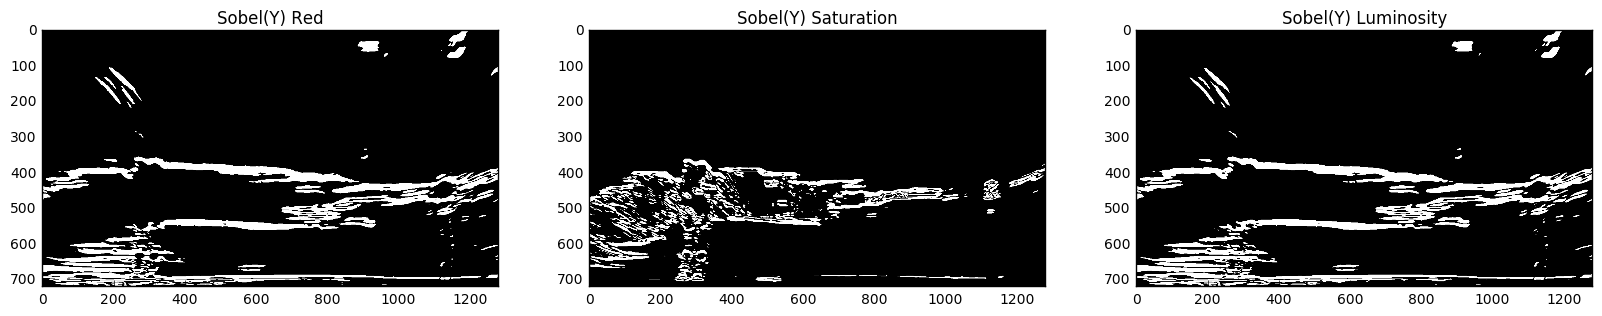

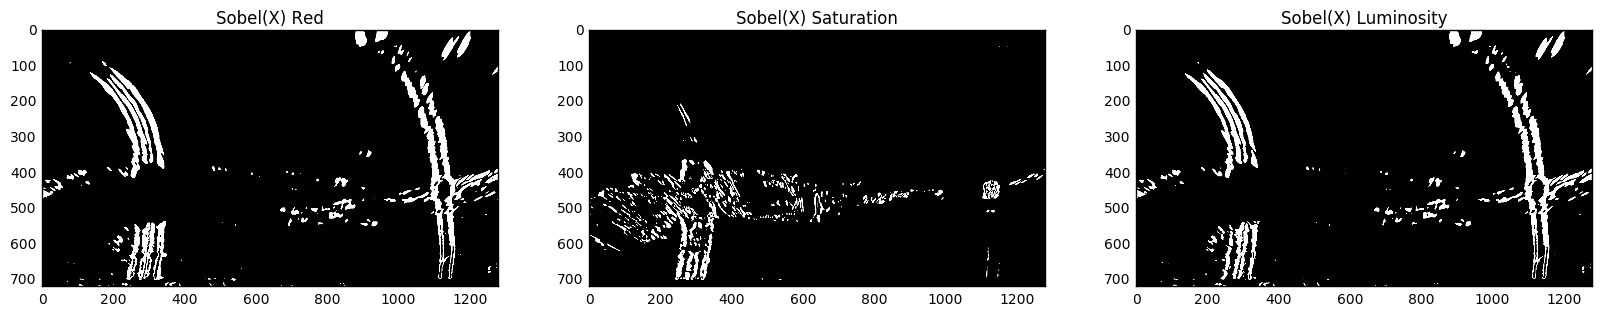

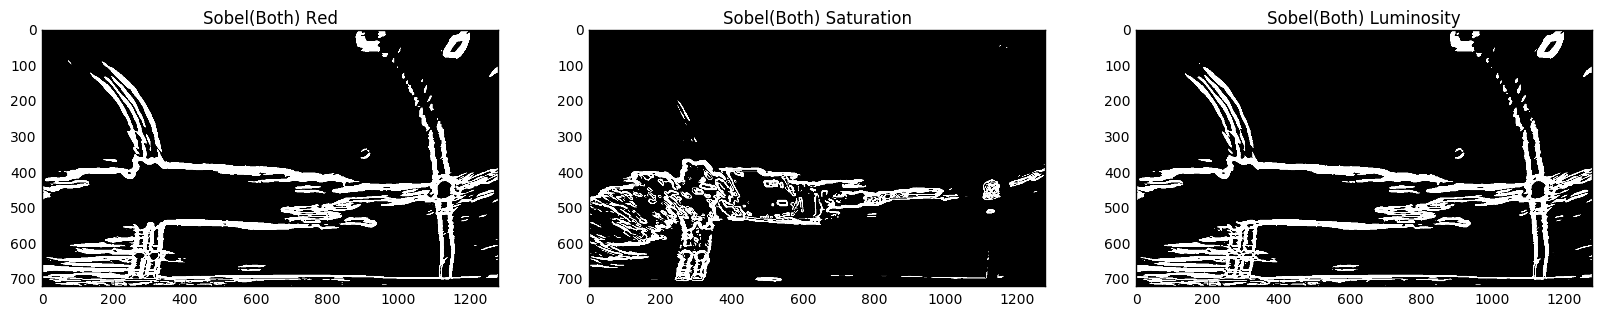

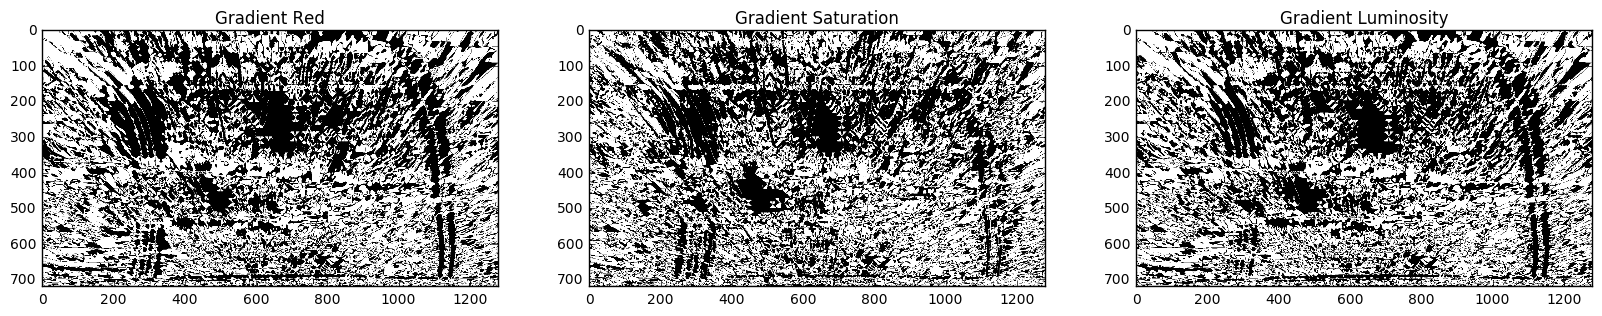

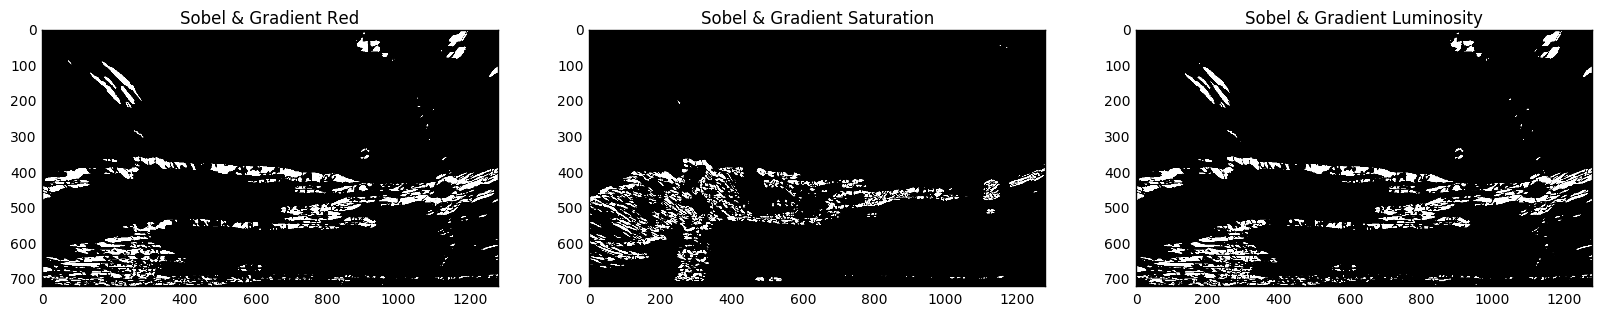

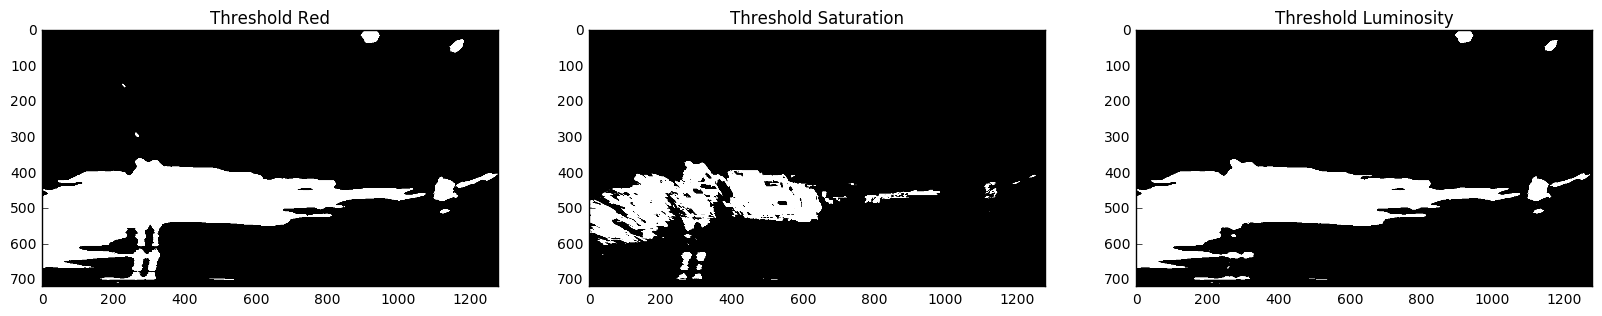

In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np

from CameraOperations import sobel_threshold, gradient_threshold, sobel_and_gradient, sobel_LSR_threshold, show_grid
from CameraOperations import threshold_rgb, threshold_hls
from ImageProcessing import image_preprocessing, augment_brightness_camera_images, image_sharpen
from LaneOperations import perspective_transform

#img_id = 206
#image = mpimg.imread("./debug_images3/{0}.jpg".format(img_id))

img_id = "1189"
image = mpimg.imread("./debug_images-harder_challenge_video/{0}.jpg".format(img_id))

#image = image_sharpen(image)
w = image.shape[1]
h = image.shape[0]
#viewport = [[540,468],[740,468],[1280,720],[0,720]]
viewport = [[round(w/2-105),round(h*.65)],[round(w/2+105),round(h*.65)],[w,h],[0,h]]
image = perspective_transform(image, viewport=viewport, offset=0, reverse=False)
r = image[:,:,0]
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s = hls[:,:,2]
l = hls[:,:,1]
show_grid((r,s,l), ("Red", "Saturation", "Luminosity"))

sobel_thresh=(30, 150)
gradient_thresh=(0.7, 1.5)
sobel_kernel=15
s_thresh=(170,240)

sobel_r = sobel_threshold(r, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
sobel_s = sobel_threshold(s, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
sobel_l = sobel_threshold(l, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
show_grid((sobel_r,sobel_s,sobel_l), ("Sobel(Y) Red", "Sobel(Y) Saturation", "Sobel(Y) Luminosity"))

sobel_r = sobel_threshold(r, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
sobel_s = sobel_threshold(s, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
sobel_l = sobel_threshold(l, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
show_grid((sobel_r,sobel_s,sobel_l), ("Sobel(X) Red", "Sobel(X) Saturation", "Sobel(X) Luminosity"))

sobel_r = sobel_threshold(r, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
sobel_s = sobel_threshold(s, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
sobel_l = sobel_threshold(l, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
show_grid((sobel_r,sobel_s,sobel_l), ("Sobel(Both) Red", "Sobel(Both) Saturation", "Sobel(Both) Luminosity"))

grad_r = gradient_threshold(r, sobel_kernel=sobel_kernel, thresh=gradient_thresh)
grad_l = gradient_threshold(l, sobel_kernel=sobel_kernel, thresh=gradient_thresh)
grad_s = gradient_threshold(s, sobel_kernel=sobel_kernel, thresh=gradient_thresh)
show_grid((grad_r,grad_s,grad_l), ("Gradient Red", "Gradient Saturation", "Gradient Luminosity"))

sg_r = sobel_and_gradient(r, sobel_kernel=sobel_kernel, sobel_thresh=sobel_thresh, gradient_thresh=gradient_thresh)
sg_l = sobel_and_gradient(l, sobel_kernel=sobel_kernel, sobel_thresh=sobel_thresh, gradient_thresh=gradient_thresh)
sg_s = sobel_and_gradient(s, sobel_kernel=sobel_kernel, sobel_thresh=sobel_thresh, gradient_thresh=gradient_thresh)
show_grid((sg_r,sg_s,sg_l), ("Sobel & Gradient Red", "Sobel & Gradient Saturation", "Sobel & Gradient Luminosity"))

t_r = threshold_rgb(r, thresh=(190,255))
t_l = threshold_hls(l, thresh=(190,255))
t_s = threshold_hls(s, thresh=(190,255))
show_grid((t_r, t_s, t_l), ("Threshold Red", "Threshold Saturation", "Threshold Luminosity"))


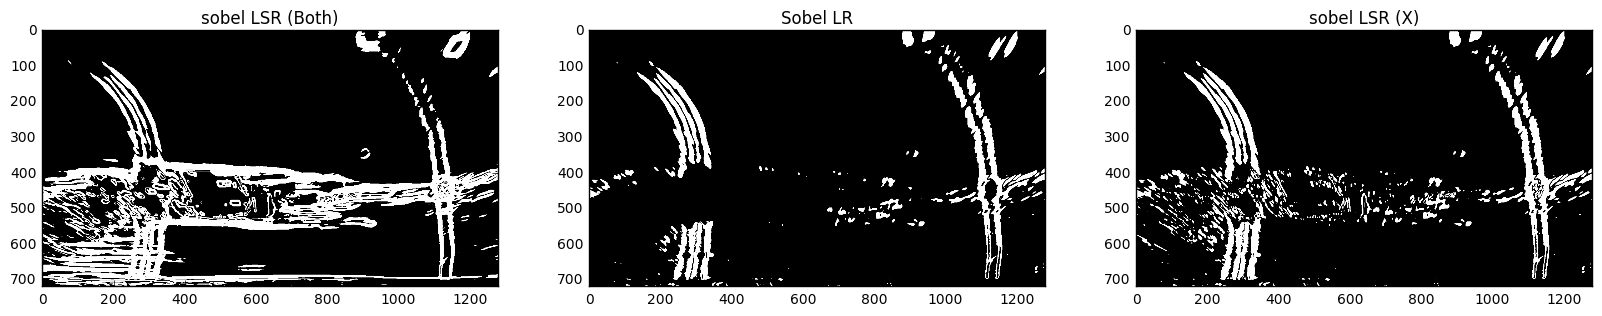

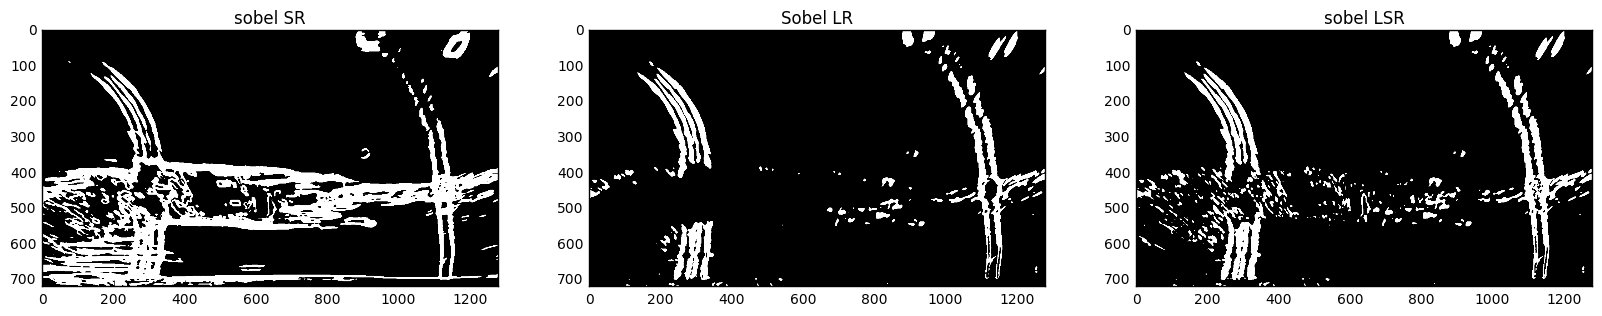

In [30]:
from CameraOperations import sobel_LR_threshold, sobel_LSR_threshold, combined_SR_threshold
from ImageProcessing import gaussian_blur

def sobel_LSR_Both_threshold(image, sobel_kernel=15, sobel_thresh=(30, 150)):
    r = image[:,:,0]
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l = hls[:,:,1]
    s = hls[:,:,2]
    sobel_r = sobel_threshold(r, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_l = sobel_threshold(l, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_s = sobel_threshold(s, orient='both', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    #t_r = threshold_rgb(r, thresh=(220,255))
    combined_slr = np.zeros_like(sobel_r)
    combined_slr[((sobel_r == 1) | (sobel_l == 1) | (sobel_s == 1))] = 1 # | (t_r == 1)
    return combined_slr

def sobel_LR_threshold(image, sobel_kernel=15, sobel_thresh=(30, 150)):
    r = image[:,:,0]
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l = hls[:,:,1]
    s = hls[:,:,2]
    sobel_r = sobel_threshold(r, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_l = sobel_threshold(l, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    sobel_s = sobel_threshold(s, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_thresh)
    #t_r = threshold_rgb(r, thresh=(220,255))
    combined_slr = np.zeros_like(sobel_r)
    combined_slr[((sobel_r == 1) | (sobel_l == 1) )] = 1 # | (sobel_s == 1) | (t_r == 1)
    return combined_slr

sobel_sr = sobel_LSR_Both_threshold(image, sobel_kernel=15, sobel_thresh=(30, 150))
sobel_lr = sobel_LR_threshold(image, sobel_kernel=15, sobel_thresh=(30, 150))
sobel_slr = sobel_LSR_threshold(image, sobel_kernel=15, sobel_thresh=(30, 150))

show_grid((sobel_sr, sobel_lr, sobel_slr), ("sobel LSR (Both)","Sobel LR", "sobel LSR (X)"))
show_grid((gaussian_blur(sobel_sr, kernel_size=9), gaussian_blur(sobel_lr, kernel_size=9), gaussian_blur(sobel_slr, kernel_size=9)), ("sobel SR","Sobel LR", "sobel LSR"))